# INTRODUCTION 

Philosphy has seen many eccentric and world-changing personalities. From the time humans have started recording history, we have written accounts of their writings, sayings and written thoughts. The school of philosphy has changed with time. We have different schools of thoughts of ancient times, popularized by the philosphers like Plato and Aristotle. However, as times grew and the focus of humans shifted from monarchies to democracies, new schools of thoughts like capitalism and communism grew. In this project my focus is to analyze different schools of thoughts, identify the underlying 'topics' in different schools of thoughts and predict some articles as to which school of thought they align with. 

## Downloading Packages

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from datetime import datetime
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from collections import Counter
from nltk.probability import FreqDist
from gensim.models import LdaModel
import nltk
import os
import string
import numpy as np
import copy
import pandas as pd
import pickle
import re
import math
import nltk,time
import gzip
import _pickle as cpickle
from gensim import models
from gensim.models import Word2Vec
import logging
import nltk
from gensim import corpora, models, similarities
stopwords_en=stopwords.words("english")

## Exploring data

In [3]:
philosphy_data_csv=pd.read_csv('C://Users/Devika/Documents/Columbia/Term 2/Applied Data Science/philosophy_data.csv')

In [4]:
philosphy_data_csv.head()

,title,author,school,sentence_spacy,sentence_str,original_publication_date,corpus_edition_date,sentence_length,sentence_lowered,tokenized_txt,lemmatized_str
0,Plato - Complete Works,Plato,plato,"What's new, Socrates, to make you leave your ...","What's new, Socrates, to make you leave your ...",-350,1997,125,"what's new, socrates, to make you leave your ...","['what', 'new', 'socrates', 'to', 'make', 'you...","what be new , Socrates , to make -PRON- lea..."
1,Plato - Complete Works,Plato,plato,Surely you are not prosecuting anyone before t...,Surely you are not prosecuting anyone before t...,-350,1997,69,surely you are not prosecuting anyone before t...,"['surely', 'you', 'are', 'not', 'prosecuting',...",surely -PRON- be not prosecute anyone before ...
2,Plato - Complete Works,Plato,plato,The Athenians do not call this a prosecution b...,The Athenians do not call this a prosecution b...,-350,1997,74,the athenians do not call this a prosecution b...,"['the', 'athenians', 'do', 'not', 'call', 'thi...",the Athenians do not call this a prosecution ...
3,Plato - Complete Works,Plato,plato,What is this you say?,What is this you say?,-350,1997,21,what is this you say?,"['what', 'is', 'this', 'you', 'say']",what be this -PRON- say ?
4,Plato - Complete Works,Plato,plato,"Someone must have indicted you, for you are no...","Someone must have indicted you, for you are no...",-350,1997,101,"someone must have indicted you, for you are no...","['someone', 'must', 'have', 'indicted', 'you',...","someone must have indict -PRON- , for -PRON- ..."


### Code Information
This data consists of many pieces of information about the authors, their school of their and their thoughts and sayings. It also contains the era of the philosphers and the latest edition of the corpus with their thoughts. The sentences are also lemmatized for ease of use and the sentence length is also given. To begin, I will create a simple timeline of the period in which each philospher existed. First, I will duplicate the dataframe as it will come in handy. 

In [5]:
philosphy_data=philosphy_data_csv.copy()

In [6]:
temp_df=philosphy_data_csv.sort_values(by=['original_publication_date'],ascending=True)
temp_df=pd.DataFrame(temp_df.loc[:, ['author','original_publication_date']].drop_duplicates().values) 
dates = temp_df.iloc[:,1]
names = temp_df.iloc[:,0]
#Removing negative value as python does not accept negative years as dates
names=names[4:]
dates=dates[4:].astype(str)
dates = [datetime.strptime(d, "%Y") for d in dates]

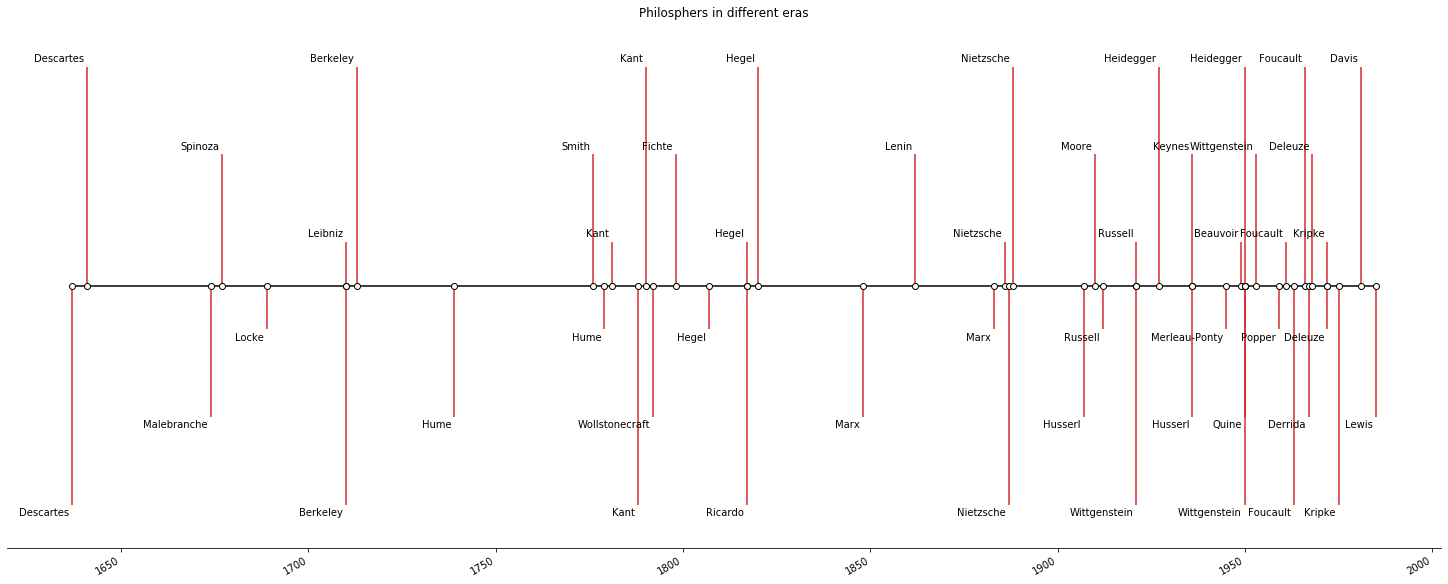

In [7]:
# Choose some nice levels
levels = np.tile([-5, 5, -3, 3, -1, 1],
                 int(np.ceil(len(dates)/6)))[:len(dates)]

# Create figure and plot a stem plot with the date
fig, ax = plt.subplots(figsize=(20, 8), constrained_layout=True)
ax.set(title="Philosphers in different eras")

markerline, stemline, baseline = ax.stem(dates, levels,
                                         linefmt="C3-", basefmt="k-",
                                         use_line_collection=True)

plt.setp(markerline, mec="k", mfc="w", zorder=3)

# Shift the markers to the baseline by replacing the y-data by zeros.
markerline.set_ydata(np.zeros(len(dates)))

# annotate lines
vert = np.array(['top', 'bottom'])[(levels > 0).astype(int)]
for d, l, r, va in zip(dates, levels, names, vert):
    ax.annotate(r, xy=(d, l), xytext=(-3, np.sign(l)*3),
                textcoords="offset points", va=va, ha="right")

# format xaxis with 100 month intervals
ax.get_xaxis().set_major_locator(mdates.YearLocator(50))
ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%Y"))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

# remove y axis and spines
ax.get_yaxis().set_visible(False)
for spine in ["left", "top", "right"]:
    ax.spines[spine].set_visible(False)

ax.margins(y=0.1)
plt.show()

#### Explanation
The above graph shows the different time periods in which the philosphers were acive. Note that one philospher has been mentioned more than once, depending on the times their accounts are from. It is also important to note that some dates are not parsed by python and hence philosphers before 1000 AD are not shown above. This timeline gives some insights about the eras of philosphers. It shows that Descartes was active before 1650 and Hume came a century later. It precisely captures the arrival of Smith and Hime. The graph also depicts the modern authors like Lewis and Kripke.

In [19]:
temp_df=philosphy_data_csv.sort_values(by=['original_publication_date'],ascending=True)
temp_df=pd.DataFrame(temp_df.loc[:, ['school','original_publication_date']].drop_duplicates().values) 
dates = temp_df.iloc[:,1]
names = temp_df.iloc[:,0]
names=names[4:]
dates=dates[4:].astype(str)
dates

4     1637
5     1641
6     1674
7     1677
8     1689
9     1710
10    1710
11    1713
12    1739
13    1776
14    1779
15    1781
16    1788
17    1790
18    1792
19    1798
20    1807
21    1817
22    1817
23    1820
24    1848
25    1862
26    1883
27    1886
28    1887
29    1888
30    1907
31    1910
32    1912
33    1921
34    1927
35    1936
36    1936
37    1945
38    1949
39    1950
40    1950
41    1953
42    1959
43    1961
44    1963
45    1966
46    1967
47    1968
48    1972
49    1972
50    1975
51    1981
52    1985
Name: 1, dtype: object

C:\Users\Devika\anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  del sys.path[0]


ValueError: x and y must have same first dimension, but have shapes (49,) and (51,)

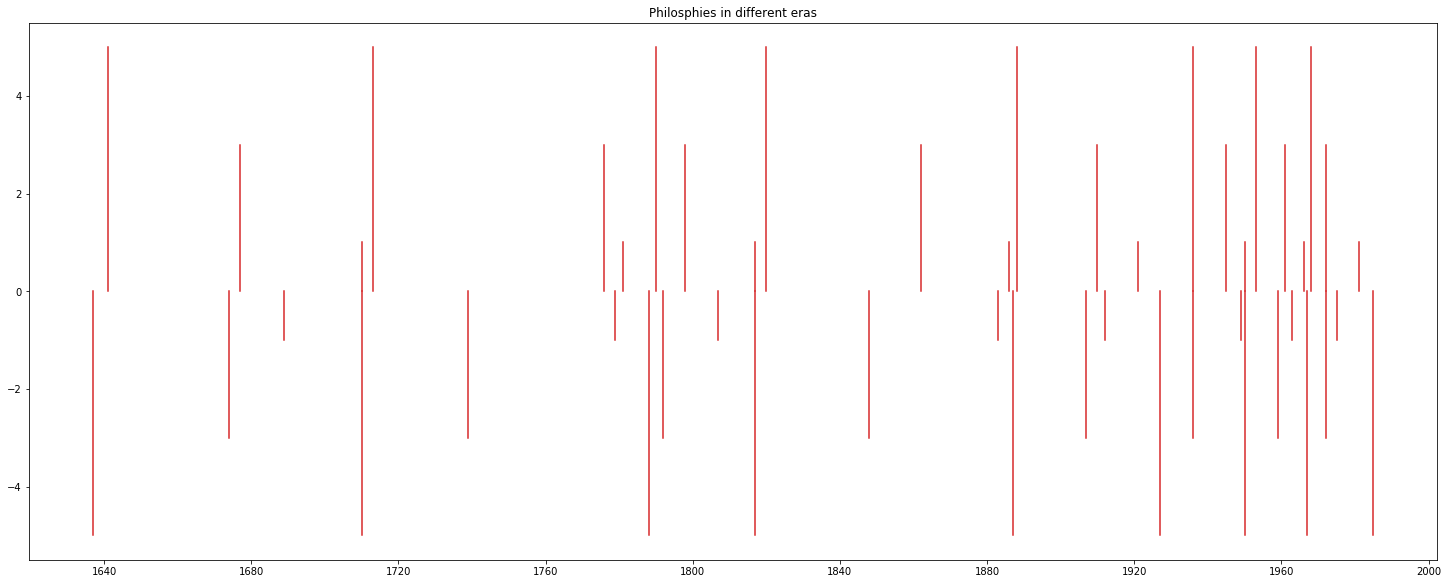

In [21]:
dates = temp_df.iloc[:,1]
names = temp_df.iloc[:,0]
#Removing negative value as python does not accept negative years as dates
names=names[4:]
dates=dates[4:].astype(str)
dates = [datetime.strptime(d, "%Y") for d in dates]

# Create figure and plot a stem plot with the date
fig, ax = plt.subplots(figsize=(20, 8), constrained_layout=True)
ax.set(title="Philosphies in different eras")

markerline, stemline, baseline = ax.stem(dates, levels,
                                         linefmt="C3-", basefmt="k-",
                                         use_line_collection=True)

plt.setp(markerline, mec="k", mfc="w", zorder=3)

# Shift the markers to the baseline by replacing the y-data by zeros.
markerline.set_ydata(np.zeros(len(dates)))

# annotate lines
vert = np.array(['top', 'bottom'])[(levels > 0).astype(int)]
for d, l, r, va in zip(dates, levels, names, vert):
    ax.annotate(r, xy=(d, l), xytext=(-3, np.sign(l)*3),
                textcoords="offset points", va=va, ha="right")

# format xaxis with 100 month intervals
ax.get_xaxis().set_major_locator(mdates.YearLocator(50))
ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%Y"))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

# remove y axis and spines
ax.get_yaxis().set_visible(False)
for spine in ["left", "top", "right"]:
    ax.spines[spine].set_visible(False)

ax.margins(y=0.1)
plt.show()

#### Explanation
The above graph shows the different time periods in which the different schools of thoughts were prevalent. Note that one school has been mentioned more than once, depending on the times their accounts are from. It is also important to note that some dates are not parsed by python and hence philosphers before 1000 AD are not shown above. 

This timeline gives some insights about the rise of ideas in different eras. Rationalism nad Empricism Were popular schools in the medieval eras. However, the 1800s witnessed many philospers with german idealism. It is interesting to note that first world war happened after 100 years of german idealism. Could it have led the germans into a sense of pride and nationalism which resulted in war? German idealism is followed by other popular schools like capitalism and communism. The modern era philosphers have shifted more towards analytic schools.

## Data Analysis

### Code Information
Now I will analyse the different schools of thoughts. I will roll up the data to make the data unique at author-sentence level. I will use this data to first analyze the different topics selected school and then use LSI algorithm for predicting the most related school for a selected sentence or paragraph.

### Topic Selection

In [9]:
import ipywidgets as widgets

In [10]:
w=widgets.Dropdown(
    options=['plato','aristotle','empiricism','rationalism','analytic','continental','phenomenology','german_idealism','communism','capitalism','stoicism','nietzsche','feminism'],
    value='plato',
    description='Select a school of thought to find the topics in it:',
)

In [11]:
def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        print("changed to %s" % change['new'])
    return change['new']

### Code Information
User can select any school of thought and the corresponding topics would be shown to the user.

In [12]:
w.observe(on_change)
#print(selected_topics)
display(w)

Dropdown(description='Select a school of thought to find the topics in it:', options=('plato', 'aristotle', 'e…

changed to analytic


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
rslt_df = philosphy_data_csv[philosphy_data_csv['school']==w.value] 
vectorizer = TfidfVectorizer(stop_words='english', 
max_features= 1000, # keep top 1000 terms 
max_df = 0.5, 
smooth_idf=True)

X = vectorizer.fit_transform(rslt_df['sentence_lowered'])

#X.shape # check shape of the document-term matrix

# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=10, algorithm='randomized', n_iter=100, random_state=122)

svd_model.fit(X)

#len(svd_model.components_)
terms = vectorizer.get_feature_names()
wordcloud_string=''
for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    for t in sorted_terms:
        wordcloud_string+=t[0]+' '

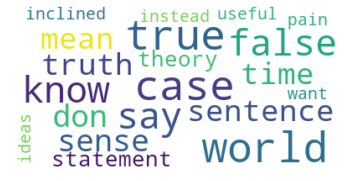

In [14]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=20, background_color="white").generate(wordcloud_string)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Explanation
The above figure shows the words in the top topics of the selected school by the user. Analysing different schools gives an insight into the basic philosphy of each school. Plato and Aristotle's writings are more about men and understanding. Rationalists' writing are more about good and evil and love, whereas feminists writing are about women and workers etc. 

### Predicting school of new sentences

### Code Information
First preprocessing the test and training data to remove stopwords and anagrams in each. Words less than 2 characters are removed, as they are seldom important. 

In [14]:
def remove_stopwords_test(cut_keyword):
    stop_words = set(stopwords.words('english'))
    filtered_sentence = []  
    for words in cut_keyword:
            if words not in stop_words and len(words)>=3: 
                filtered_sentence.append(words)
    return filtered_sentence

In [15]:
def remove_stopwords_train(cut_keyword):
    stop_words = set(stopwords.words('english'))
    filtered_sentence = []  
    for l in cut_keyword:
        temp=[]
        for w in l:
            if w not in stop_words and len(w)>=3: 
                temp.append(w)
        filtered_sentence.append(temp)
    return filtered_sentence

### Code Information
Since the combined dataset of all the authors is huge, training will take a lot of time. Therefore only a select few sentences of each school is used for training the data. 

In [16]:
philosphy_data['sentence_lowered']=philosphy_data['sentence_lowered'].apply(str)
philosphy_data=philosphy_data.groupby('school')['sentence_lowered'].apply(''.join).reset_index()
philosphy_data['paragraph']=philosphy_data['sentence_lowered'].str[:100000]

### Code Information
The data below is test data. It can be changed and schools of new sentences can be predicted. Just for fun, snippets of Trump's tweet is used in test data for finding the school associated with it. It can be changed to find school of newer sentences. 

In [25]:
test_data="The concept of global warming was created by and for the Chinese in order to make US manufacturing non-competitive. Sorry losers and haters, but my I.Q. is one of the highest - and you all know it! Please don't feel so stupid or insecure, it's not your fault. 26,000 unreported sexual assaults in the military-only 238 convictions."

In [26]:
training_data=philosphy_data['paragraph'].iloc[0:]
philosphy_school=philosphy_data['school'].iloc[0:]

philosphy_data_sim=pd.DataFrame()
philosphy_data_sim['school']=philosphy_data['school'].iloc[0:]
philosphy_data_sim['paragraph']=philosphy_data['paragraph'].iloc[0:]

#keyword=remove_stopwords([text for text in test_data.lower().split()])
tokenized = nltk.word_tokenize(test_data)
keyword= [word for word,pos in nltk.pos_tag(tokenized) if 'NN' in pos or 'JJ' in pos ]
keyword=remove_stopwords_test(keyword)
keyword = list(dict.fromkeys(keyword))
texts = [[word for word,pos in nltk.pos_tag(nltk.word_tokenize(doc)) if 'NN' in pos or 'JJ' in pos] for doc in training_data]
#texts = [[text.lower() for text in doc.split()] for doc in training_data]
#texts = [jieba.lcut(str(text)) for text in training_data]
texts=remove_stopwords_train(texts)
#texts=remove_anagram(texts)

#texts=remove_stopwords_lol(texts)
dictionary = corpora.Dictionary(texts)
feature_cnt = len(dictionary.token2id)
corpus = [dictionary.doc2bow(text) for text in texts]
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
lsi = models.LsiModel(corpus_tfidf, id2word=dictionary)  # initialize an LSI transformation
kw_vector = dictionary.doc2bow(keyword)
vec_lsi = lsi[kw_vector]  # convert the query to LSI space

index = similarities.MatrixSimilarity(lsi[corpus])  # transform corpus to LSI space and index it

sim = index[vec_lsi]
philosphy_data_sim['sim']=sim
philosphy_data_sim=philosphy_data_sim.sort_values(by=['sim'],ascending=False)
if(philosphy_data_sim['sim'].iloc[0]==0):
    print("This text is not similar to any philosophical text this system has encountered till now.")
else:
    print("The text is similar to",philosphy_data_sim['school'].iloc[0],"school of thought with a similarity of",philosphy_data_sim['sim'].iloc[0])
#for i in range(len(sim)):
    #print('keyword is similar to text -> %d: %.2f' % (philosphy_data_sim.iloc[i:i + 1], sim[i]))

The text is similar to german_idealism school of thought with a similarity of 0.7626275


### Code Information
The top 3 school of thoughts are shown below as per the words and topics identified by LSI in the training data and test data. 

[Text(0.5, 1.0, 'Top 3 similar schools of thoughts to your words')]

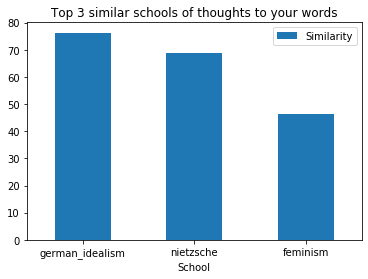

In [32]:
df = pd.DataFrame({'School':philosphy_data_sim['school'][:3], 'Similarity':philosphy_data_sim['sim'][:3]*100})
ax = df.plot.bar(x='School', y='Similarity', rot=0)
ax.set(title="Top 3 similar schools of thoughts to your words")

#### Explanation
The model suggests Trump's tweets are similar to German Idealism philosphy. This is pretty interesting. On analysing the words in German Idealism, one can find words like unity, duty, judgement, and freedom etc. This might be the reason behind Trump's school prediction as German Idealism. 